# Modelos de Aprendizaje Supervisado: Regresión 

## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [2]:
archivos= []
rango = range(1, 31, 1)
for i in rango:
    nombre = 'DATOSCLIENTE' + str(i) + '.csv'
    archivos.append(nombre)

for i in range(len(archivos)):
    url= 'https://raw.githubusercontent.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/main/' + archivos[i]
    temp = pd.read_csv(url)
    temp['idCliente'] = i + 1
    if i == 0:
        clientes = temp.copy()
    else:
        clientes = pd.concat([clientes, temp])
clientes

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1
...,...,...,...,...,...,...
11410,2022-04-21 10:00:00,0.960105,0.473234,1273.150602,1027.084539,30
11411,2022-04-21 11:00:00,0.624300,0.699936,1063.524968,1205.829819,30
11412,2022-04-21 12:00:00,0.985633,0.123560,1207.284283,1127.893714,30
11413,2022-04-21 13:00:00,0.710436,0.399262,1205.012971,1090.835898,30


## Preparación de datos

In [3]:
clientes['Fecha'] = pd.to_datetime(clientes['Fecha'])
clientes['Fecha2'] = clientes['Fecha'].dt.date
clientes['Dia'] = clientes['Fecha'].dt.day
clientes['Mes'] = clientes['Fecha'].dt.month
clientes['Año'] = clientes['Fecha'].dt.year
clientes['Hora'] = clientes['Fecha'].dt.hour
clientes['Minuto'] = clientes['Fecha'].dt.minute
clientes['Año_Mes'] = clientes['Fecha'].dt.to_period('M')
clientes = clientes[~(clientes['Año_Mes'] == '2023-04')]
clientes.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente,Fecha2,Dia,Mes,Año,Hora,Minuto,Año_Mes
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,2021-01-01,1,1,2021,0,0,2021-01
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,2021-01-01,1,1,2021,1,0,2021-01
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,2021-01-01,1,1,2021,2,0,2021-01
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,2021-01-01,1,1,2021,3,0,2021-01
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,2021-01-01,1,1,2021,4,0,2021-01


## Energía Activa

### Preprocesamiento de datos

In [54]:
np.random.seed(123)

datos_active_energy = clientes[['Active_energy', 'idCliente', 'Dia', 'Mes', 'Año', 'Hora', 'Minuto']]

X = datos_active_energy.drop('Active_energy', axis=1)
y = datos_active_energy['Active_energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
lista_RMSE_active = []

### Modelos

#### Redes Neuronales

In [56]:
tf.random.set_seed(123)

def mejor_modelo_nn(X_train_scaled,
                              y_train,
                              X_test_scaled,
                              y_test,
                              num_capas_list,
                              num_neuronas_list,
                              funciones_activacion):
    
    best_model = None
    best_params = {}
    best_rmse = float('inf')  # Inicializamos con infinito para encontrar el mínimo
    
    for num_capas in num_capas_list:
        for num_neuronas in num_neuronas_list:
            for fun_activacion in funciones_activacion:
                print('Modelo entrenado con los siguientes parámetros:')
                print(f'{num_capas} capas, {num_neuronas} neuronas por capa y función de activación {fun_activacion}')
                
                # Crear modelo
                model = Sequential()
                model.add(Dense(num_neuronas, input_dim=X_train_scaled.shape[1], activation=fun_activacion))
                for _ in range(num_capas - 1):
                    model.add(Dense(num_neuronas, activation=fun_activacion))
                model.add(Dense(1))
                
                # Compilar modelo
                model.compile(optimizer='adam', loss='mean_squared_error')
                
                # Entrenar modelo
                model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
                
                # Evaluar modelo
                y_pred = model.predict(X_test_scaled)
                rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
                
                print(f'RMSE: {rmse}')
                
                # Actualizar el mejor modelo si corresponde
                if rmse < best_rmse:
                    best_model = model
                    best_params = {'num_capas': num_capas, 'num_neuronas': num_neuronas, 'fun_activacion': fun_activacion}
                    best_rmse = rmse
    
    print('Mejores parámetros:')
    print(best_params)
    print('\nMejor RMSE:')
    print(best_rmse)
    
    return best_model, best_params, best_rmse

# Definición de hiperparámetros
num_capas_list = [1, 2, 3]
num_neuronas_list = [32, 64, 128]
funciones_activacion = ['relu', 'sigmoid']

# Selección del mejor modelo y parámetros
best_model, best_params, RMSE_NN = mejor_modelo_nn(
    X_train_scaled, y_train, X_test_scaled, y_test, num_capas_list, num_neuronas_list, funciones_activacion)

# Se guardan los valores del RMSE
print(best_params)
print(RMSE_NN)
lista_RMSE_active.append(RMSE_NN)

{'num_capas': 3, 'num_neuronas': 128, 'fun_activacion': 'relu'}
0.59


#### Random Forest

El parámetro max_depth que mejor calibra el modelo es 17


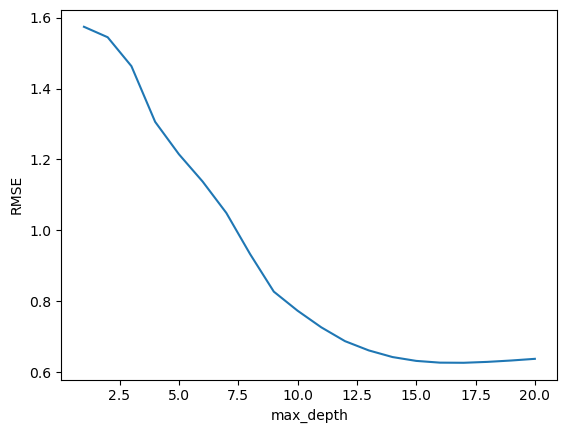

In [7]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
RF_max_depth_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_RF_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in RF_max_depth_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = max_depth)
    RMSE_RF_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(RF_max_depth_range, RMSE_RF_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
best_RF_max_depth = RF_max_depth_range[RMSE_RF_max_depth.index(min(RMSE_RF_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {best_RF_max_depth}')

El parámetro n_estimators que mejor calibra el modelo es 460


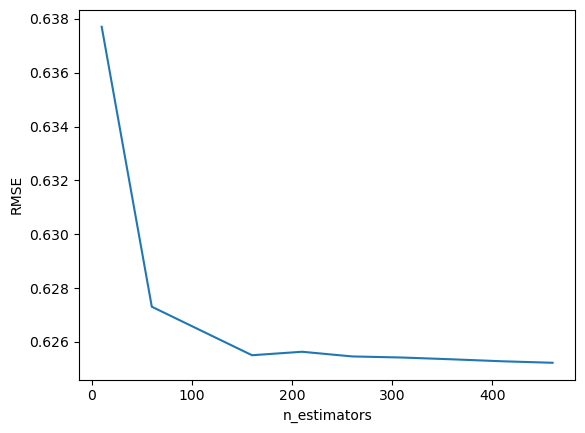

In [8]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
RF_n_estimators_range = range(10, 510, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_RF_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in RF_n_estimators_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = n_estimators)
    RMSE_RF_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(RF_n_estimators_range, RMSE_RF_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
best_RF_n_estimators = RF_n_estimators_range[RMSE_RF_n_estimators.index(min(RMSE_RF_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {best_RF_n_estimators}')

El parámetro min_samples_leaf que mejor calibra el modelo es 4


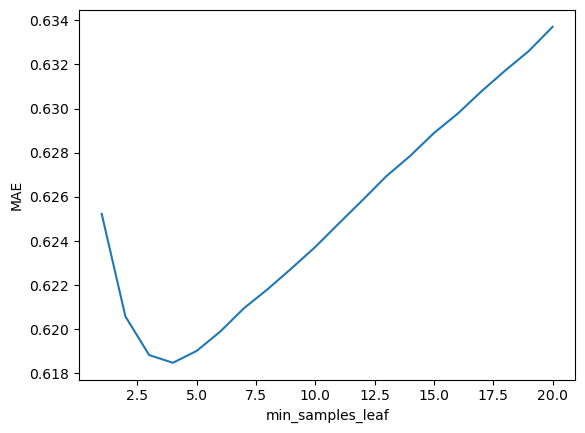

In [9]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_leaf
RF_min_samples_leaf_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_leaf
RMSE_RF_min_samples_leaf = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_leaf
for min_samples_leaf in RF_min_samples_leaf_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = min_samples_leaf)
    RMSE_RF_min_samples_leaf.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_leaf
plt.plot(RF_min_samples_leaf_range, RMSE_RF_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('MAE')

# Parámetro min_samples_leaf que mejor calibra el modelo
best_RF_min_samples_leaf = RF_min_samples_leaf_range[RMSE_RF_min_samples_leaf.index(min(RMSE_RF_min_samples_leaf))]
print(f'El parámetro min_samples_leaf que mejor calibra el modelo es {best_RF_min_samples_leaf}')

El parámetro min_samples_split que mejor calibra el modelo es 4


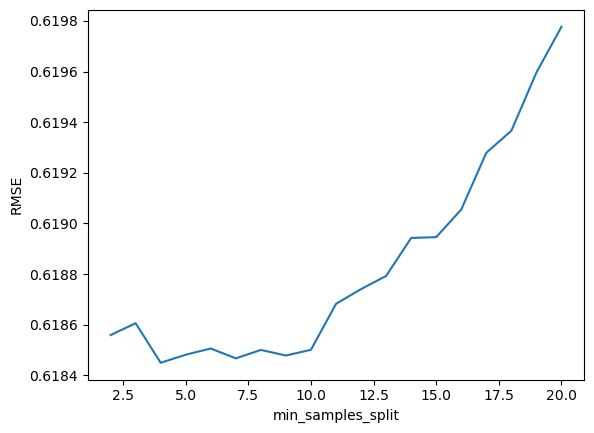

In [10]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_split
RF_min_samples_split_range = range(2, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_split
RMSE_RF_min_samples_split = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_split
for min_samples_split in RF_min_samples_split_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = min_samples_split)
    RMSE_RF_min_samples_split.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_split
plt.plot(RF_min_samples_split_range, RMSE_RF_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('RMSE')

# Parámetro min_samples_split que mejor calibra el modelo
best_RF_min_samples_split = RF_min_samples_split_range[RMSE_RF_min_samples_split.index(min(RMSE_RF_min_samples_split))]
print(f'El parámetro min_samples_split que mejor calibra el modelo es {best_RF_min_samples_split}')

In [57]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest calibrado con el set de train 
RF_reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = best_RF_min_samples_split).fit(X_train_scaled, y_train)

# Predicción con el set de test
y_pred = RF_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE
RMSE_RF = round(metrics.mean_squared_error(y_pred, y_test, squared = False), 2)
print(f'El RMSE del modelo es de {RMSE_RF}')

# Se guardan los valores del RMSE
lista_RMSE_active.append(RMSE_RF)

El RMSE del modelo es de 1.87


#### XGBoost

El parámetro max_depth que mejor calibra el modelo es 10


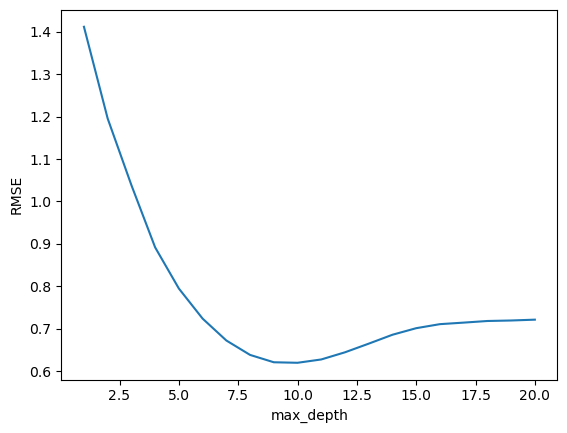

In [12]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
XGB_max_depth_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_XGB_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in XGB_max_depth_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = max_depth)
    RMSE_XGB_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(XGB_max_depth_range, RMSE_XGB_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
XGB_best_max_depth = XGB_max_depth_range[RMSE_XGB_max_depth.index(min(RMSE_XGB_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {XGB_best_max_depth}')

El parámetro learning_rate que mejor calibra el modelo es 0.2


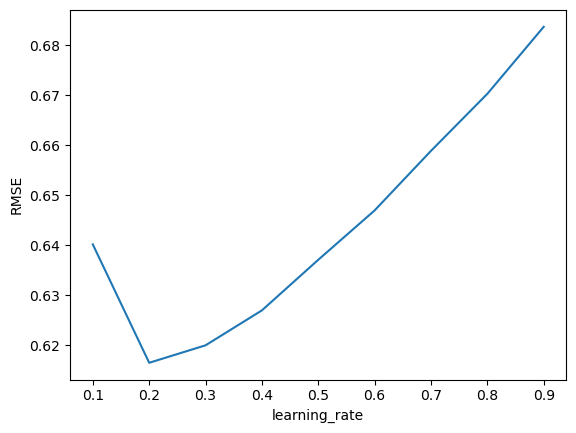

In [13]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de learning_rate
XGB_learning_rate_range = np.arange(0.1, 1, 0.1)

# Definición de lista para almacenar el RMSE promedio de cada valor de learning_rate
RMSE_XGB_learning_rate = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for learning_rate in XGB_learning_rate_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = learning_rate)
    RMSE_XGB_learning_rate.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de learning_rate
plt.plot(XGB_learning_rate_range, RMSE_XGB_learning_rate)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')

# Parámetro learning_rate que mejor calibra el modelo
XGB_best_learning_rate = XGB_learning_rate_range[RMSE_XGB_learning_rate.index(min(RMSE_XGB_learning_rate))]
print(f'El parámetro learning_rate que mejor calibra el modelo es {XGB_best_learning_rate}')

El parámetro n_estimators que mejor calibra el modelo es 110


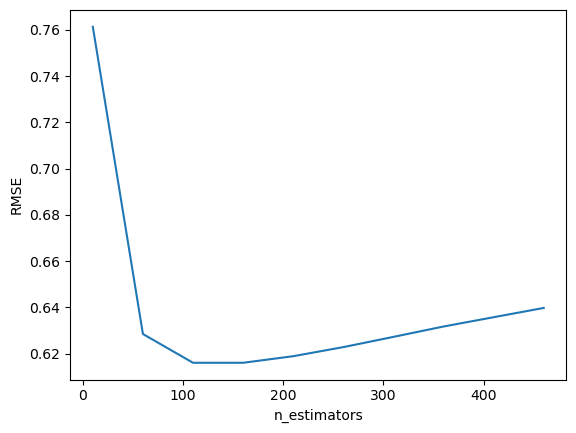

In [14]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
XGB_n_estimators_range = range(10, 510, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_XGB_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in XGB_n_estimators_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = n_estimators)
    RMSE_XGB_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(XGB_n_estimators_range, RMSE_XGB_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
XGB_best_n_estimators = XGB_n_estimators_range[RMSE_XGB_n_estimators.index(min(RMSE_XGB_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {XGB_best_n_estimators}')

El parámetro gamma que mejor calibra el modelo es 0


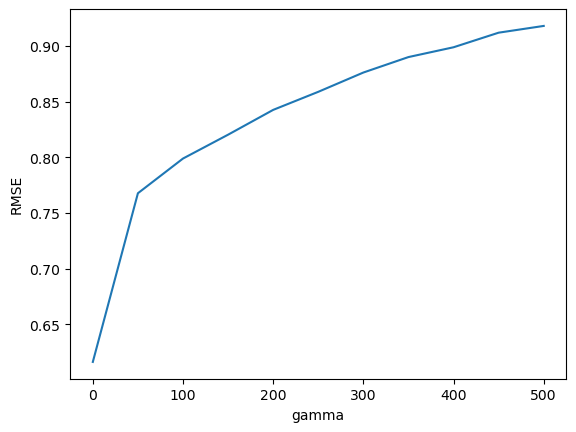

In [15]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de gamma
XGB_gamma_range = range(0, 501, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de gamma
RMSE_XGB_gamma = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for gamma in XGB_gamma_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = gamma)
    RMSE_XGB_gamma.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de gamma
plt.plot(XGB_gamma_range, RMSE_XGB_gamma)
plt.xlabel('gamma')
plt.ylabel('RMSE')

# Parámetro gamma que mejor calibra el modelo
XGB_best_gamma = XGB_gamma_range[RMSE_XGB_gamma.index(min(RMSE_XGB_gamma))]
print(f'El parámetro gamma que mejor calibra el modelo es {XGB_best_gamma}')

El parámetro colsample_bytree que mejor calibra el modelo es 0.9


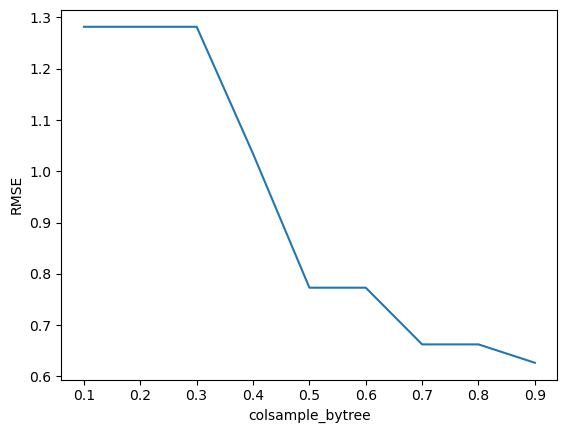

In [16]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de colsample_bytree
XGB_colsample_bytree_range = np.arange(0.1, 1, 0.1)

# Definición de lista para almacenar el RMSE promedio de cada valor de colsample_bytree
RMSE_XGB_colsample_bytree = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for colsample_bytree in XGB_colsample_bytree_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = XGB_best_gamma,
                       colsample_bytree = colsample_bytree)
    RMSE_XGB_colsample_bytree.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de colsample_bytree
plt.plot(XGB_colsample_bytree_range, RMSE_XGB_colsample_bytree)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

# Parámetro colsample_bytree que mejor calibra el modelo
XGB_best_colsample_bytree = XGB_colsample_bytree_range[RMSE_XGB_colsample_bytree.index(min(RMSE_XGB_colsample_bytree))]
print(f'El parámetro colsample_bytree que mejor calibra el modelo es {XGB_best_colsample_bytree}')

In [58]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de XGBoost calibrado con el set de train 
XGB_reg = XGBRegressor(n_jobs = -1,
                        max_depth = XGB_best_max_depth,
                        learning_rate = XGB_best_learning_rate,
                        n_estimators = XGB_best_n_estimators,
                        gamma = XGB_best_gamma,
                        colsample_bytree = XGB_best_colsample_bytree).fit(X_train_scaled, y_train)

# Predicción con el set de test
y_pred = XGB_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_XGB = round(metrics.mean_squared_error(y_pred, y_test, squared = False), 2)
print(f'El RMSE del modelo es de {RMSE_XGB}')

# Se guardan los valores del RMSE
lista_RMSE_active.append(RMSE_XGB)

El RMSE del modelo es de 2.07


### Comparación de modelos

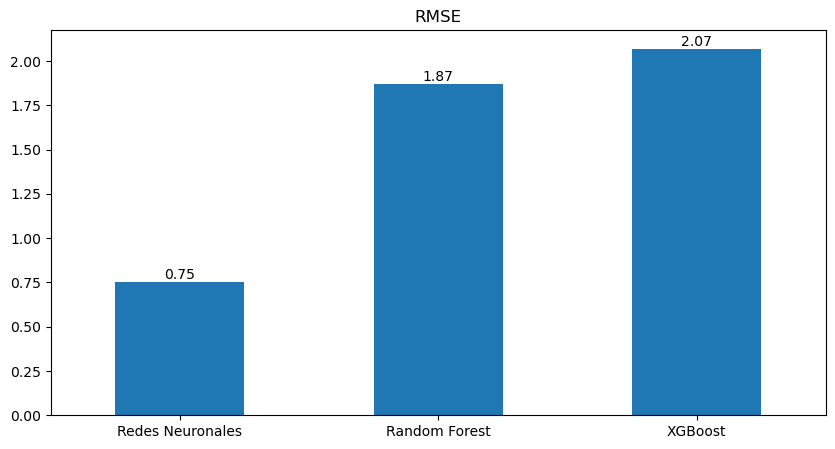

In [62]:
df_RMSE = pd.DataFrame(pd.DataFrame({'Modelo': ['Redes Neuronales', 'Random Forest', 'XGBoost'], 'RMSE': lista_RMSE_active}))

ax_RMSE = df_RMSE.plot.bar(x = 'Modelo', y = 'RMSE', rot = 0, figsize = (10, 5), legend = False, xlabel = '', title = 'RMSE')
for container in ax_RMSE.containers:
    ax_RMSE.bar_label(container)

## Energía Reactiva

In [70]:
np.random.seed(123)

datos_reactive_energy = clientes[['Reactive_energy', 'idCliente', 'Dia', 'Mes', 'Año', 'Hora', 'Minuto']]

X = datos_reactive_energy.drop('Reactive_energy', axis=1)
y = datos_reactive_energy['Reactive_energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
lista_RMSE_reactive = []

### Redes Neuronales

In [72]:
tf.random.set_seed(123)

def mejor_modelo_nn(X_train_scaled,
                              y_train,
                              X_test_scaled,
                              y_test,
                              num_capas_list,
                              num_neuronas_list,
                              funciones_activacion):
    
    best_model = None
    best_params = {}
    best_rmse = float('inf')  # Inicializamos con infinito para encontrar el mínimo
    
    for num_capas in num_capas_list:
        for num_neuronas in num_neuronas_list:
            for fun_activacion in funciones_activacion:
                print('Modelo entrenado con los siguientes parámetros:')
                print(f'{num_capas} capas, {num_neuronas} neuronas por capa y función de activación {fun_activacion}')
                
                # Crear modelo
                model = Sequential()
                model.add(Dense(num_neuronas, input_dim=X_train_scaled.shape[1], activation=fun_activacion))
                for _ in range(num_capas - 1):
                    model.add(Dense(num_neuronas, activation=fun_activacion))
                model.add(Dense(1))
                
                # Compilar modelo
                model.compile(optimizer='adam', loss='mean_squared_error')
                
                # Entrenar modelo
                model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
                
                # Evaluar modelo
                y_pred = model.predict(X_test_scaled)
                rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
                
                print(f'RMSE: {rmse}')
                
                # Actualizar el mejor modelo si corresponde
                if rmse < best_rmse:
                    best_model = model
                    best_params = {'num_capas': num_capas, 'num_neuronas': num_neuronas, 'fun_activacion': fun_activacion}
                    best_rmse = rmse
    
    print('Mejores parámetros:')
    print(best_params)
    print('\nMejor RMSE:')
    print(best_rmse)
    
    return best_model, best_params, best_rmse

# Definición de hiperparámetros
num_capas_list = [1, 2, 3]
num_neuronas_list = [32, 64, 128]
funciones_activacion = ['relu', 'sigmoid']

# Selección del mejor modelo y parámetros
best_model, best_params, RMSE_NN = mejor_modelo_nn(
    X_train_scaled, y_train, X_test_scaled, y_test, num_capas_list, num_neuronas_list, funciones_activacion)

# Se guardan los valores del RMSE
print(best_params)
print(RMSE_NN)
lista_RMSE_reactive.append(RMSE_NN)

{'num_capas': 3, 'num_neuronas': 128, 'fun_activacion': 'relu'}
0.59


### Random Forest

El parámetro max_depth que mejor calibra el modelo es 17


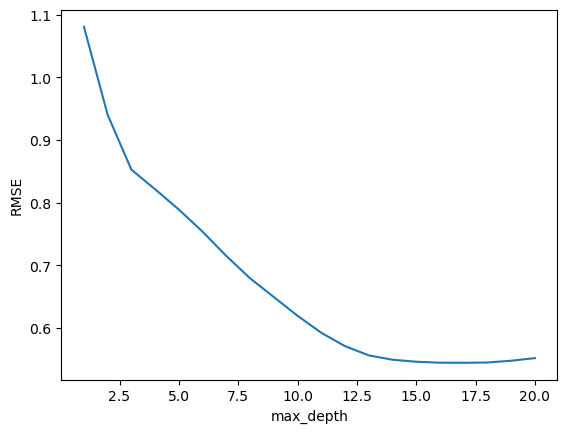

In [22]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
RF_max_depth_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_RF_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in RF_max_depth_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = max_depth)
    RMSE_RF_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(RF_max_depth_range, RMSE_RF_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
best_RF_max_depth = RF_max_depth_range[RMSE_RF_max_depth.index(min(RMSE_RF_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {best_RF_max_depth}')

El parámetro n_estimators que mejor calibra el modelo es 460


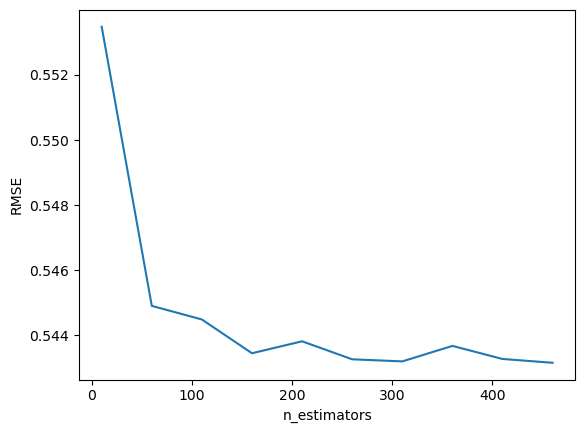

In [23]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
RF_n_estimators_range = range(10, 510, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_RF_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in RF_n_estimators_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = n_estimators)
    RMSE_RF_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(RF_n_estimators_range, RMSE_RF_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
best_RF_n_estimators = RF_n_estimators_range[RMSE_RF_n_estimators.index(min(RMSE_RF_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {best_RF_n_estimators}')

El parámetro min_samples_leaf que mejor calibra el modelo es 15


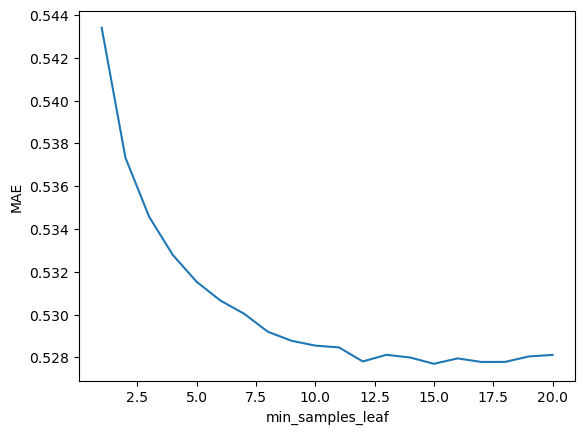

In [24]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_leaf
RF_min_samples_leaf_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_leaf
RMSE_RF_min_samples_leaf = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_leaf
for min_samples_leaf in RF_min_samples_leaf_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = min_samples_leaf)
    RMSE_RF_min_samples_leaf.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_leaf
plt.plot(RF_min_samples_leaf_range, RMSE_RF_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('MAE')

# Parámetro min_samples_leaf que mejor calibra el modelo
best_RF_min_samples_leaf = RF_min_samples_leaf_range[RMSE_RF_min_samples_leaf.index(min(RMSE_RF_min_samples_leaf))]
print(f'El parámetro min_samples_leaf que mejor calibra el modelo es {best_RF_min_samples_leaf}')

El parámetro min_samples_split que mejor calibra el modelo es 13


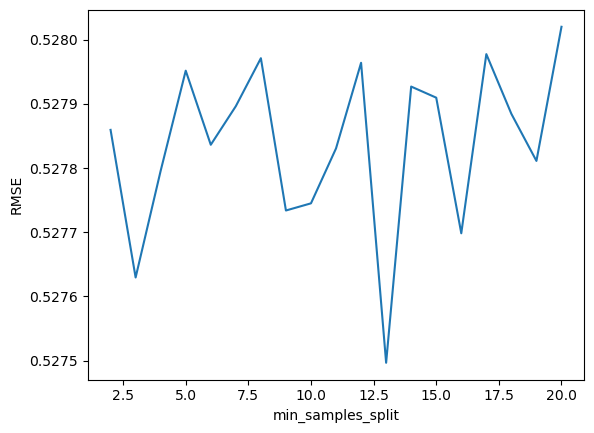

In [25]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_split
RF_min_samples_split_range = range(2, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_split
RMSE_RF_min_samples_split = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_split
for min_samples_split in RF_min_samples_split_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = min_samples_split)
    RMSE_RF_min_samples_split.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_split
plt.plot(RF_min_samples_split_range, RMSE_RF_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('RMSE')

# Parámetro min_samples_split que mejor calibra el modelo
best_RF_min_samples_split = RF_min_samples_split_range[RMSE_RF_min_samples_split.index(min(RMSE_RF_min_samples_split))]
print(f'El parámetro min_samples_split que mejor calibra el modelo es {best_RF_min_samples_split}')

In [73]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest calibrado con el set de train 
RF_reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = best_RF_min_samples_split).fit(X_train_scaled, y_train)

# Predicción con el set de test
y_pred = RF_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE
RMSE_RF = round(metrics.mean_squared_error(y_pred, y_test, squared = False), 2)
print(f'El RMSE del modelo es de {RMSE_RF}')

# Se guardan los valores del RMSE
lista_RMSE_reactive.append(RMSE_RF)

El RMSE del modelo es de 1.35


### XGBoost

El parámetro max_depth que mejor calibra el modelo es 9


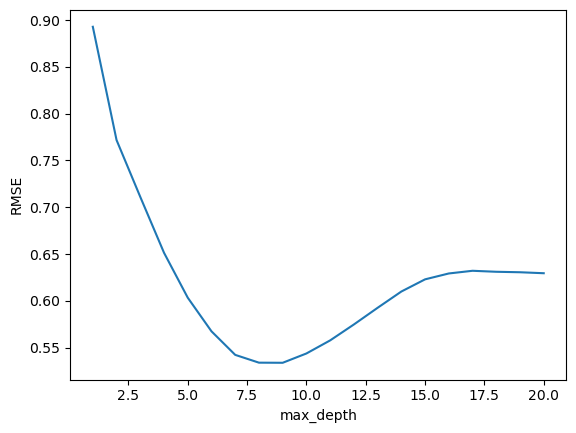

In [27]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
XGB_max_depth_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_XGB_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in XGB_max_depth_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = max_depth)
    RMSE_XGB_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(XGB_max_depth_range, RMSE_XGB_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
XGB_best_max_depth = XGB_max_depth_range[RMSE_XGB_max_depth.index(min(RMSE_XGB_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {XGB_best_max_depth}')

El parámetro learning_rate que mejor calibra el modelo es 0.2


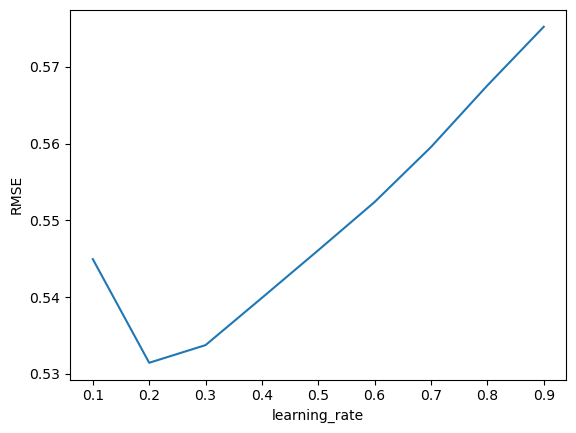

In [28]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de learning_rate
XGB_learning_rate_range = np.arange(0.1, 1, 0.1)

# Definición de lista para almacenar el RMSE promedio de cada valor de learning_rate
RMSE_XGB_learning_rate = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for learning_rate in XGB_learning_rate_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = learning_rate)
    RMSE_XGB_learning_rate.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de learning_rate
plt.plot(XGB_learning_rate_range, RMSE_XGB_learning_rate)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')

# Parámetro learning_rate que mejor calibra el modelo
XGB_best_learning_rate = XGB_learning_rate_range[RMSE_XGB_learning_rate.index(min(RMSE_XGB_learning_rate))]
print(f'El parámetro learning_rate que mejor calibra el modelo es {XGB_best_learning_rate}')

El parámetro n_estimators que mejor calibra el modelo es 110


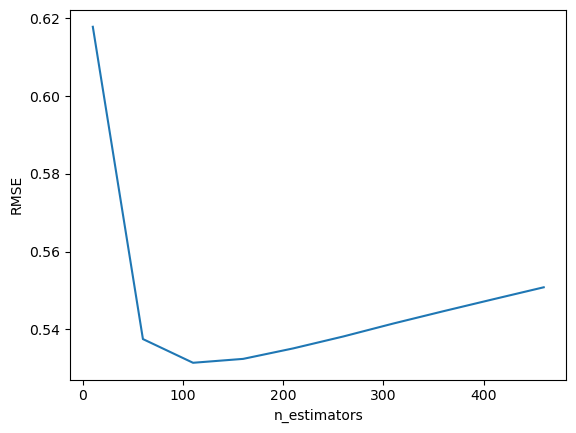

In [29]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
XGB_n_estimators_range = range(10, 510, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_XGB_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in XGB_n_estimators_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = n_estimators)
    RMSE_XGB_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(XGB_n_estimators_range, RMSE_XGB_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
XGB_best_n_estimators = XGB_n_estimators_range[RMSE_XGB_n_estimators.index(min(RMSE_XGB_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {XGB_best_n_estimators}')

El parámetro gamma que mejor calibra el modelo es 0


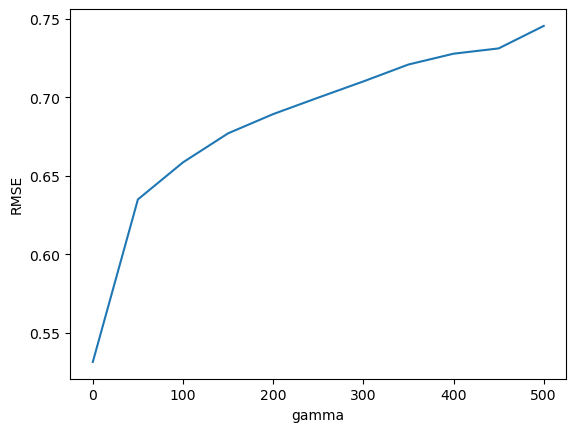

In [30]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de gamma
XGB_gamma_range = range(0, 501, 50)

# Definición de lista para almacenar el RMSE promedio de cada valor de gamma
RMSE_XGB_gamma = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for gamma in XGB_gamma_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = gamma)
    RMSE_XGB_gamma.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de gamma
plt.plot(XGB_gamma_range, RMSE_XGB_gamma)
plt.xlabel('gamma')
plt.ylabel('RMSE')

# Parámetro gamma que mejor calibra el modelo
XGB_best_gamma = XGB_gamma_range[RMSE_XGB_gamma.index(min(RMSE_XGB_gamma))]
print(f'El parámetro gamma que mejor calibra el modelo es {XGB_best_gamma}')

El parámetro colsample_bytree que mejor calibra el modelo es 0.9


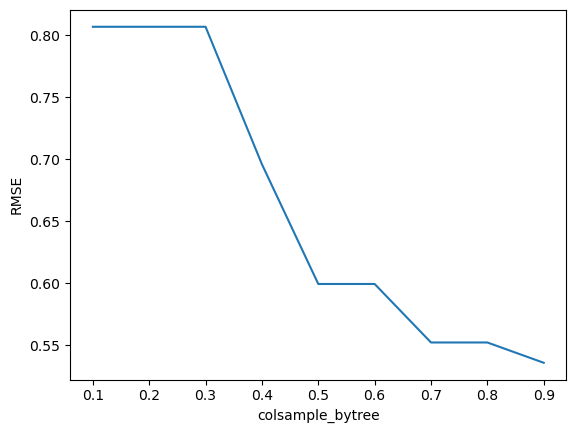

In [31]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de colsample_bytree
XGB_colsample_bytree_range = np.arange(0.1, 1, 0.1)

# Definición de lista para almacenar el RMSE promedio de cada valor de colsample_bytree
RMSE_XGB_colsample_bytree = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for colsample_bytree in XGB_colsample_bytree_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = XGB_best_gamma,
                       colsample_bytree = colsample_bytree)
    RMSE_XGB_colsample_bytree.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de colsample_bytree
plt.plot(XGB_colsample_bytree_range, RMSE_XGB_colsample_bytree)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

# Parámetro colsample_bytree que mejor calibra el modelo
XGB_best_colsample_bytree = XGB_colsample_bytree_range[RMSE_XGB_colsample_bytree.index(min(RMSE_XGB_colsample_bytree))]
print(f'El parámetro colsample_bytree que mejor calibra el modelo es {XGB_best_colsample_bytree}')

In [74]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de XGBoost calibrado con el set de train 
XGB_reg = XGBRegressor(n_jobs = -1,
                        max_depth = XGB_best_max_depth,
                        learning_rate = XGB_best_learning_rate,
                        n_estimators = XGB_best_n_estimators,
                        gamma = XGB_best_gamma,
                        colsample_bytree = XGB_best_colsample_bytree).fit(X_train_scaled, y_train)

# Predicción con el set de test
y_pred = XGB_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_XGB = round(metrics.mean_squared_error(y_pred, y_test, squared = False), 2)
print(f'El RMSE del modelo es de {RMSE_XGB}')

# Se guardan los valores del RMSE
lista_RMSE_reactive.append(RMSE_XGB)

El RMSE del modelo es de 1.42


### Comparación de modelos

In [75]:
lista_RMSE_reactive

[0.59, 1.35, 1.42]

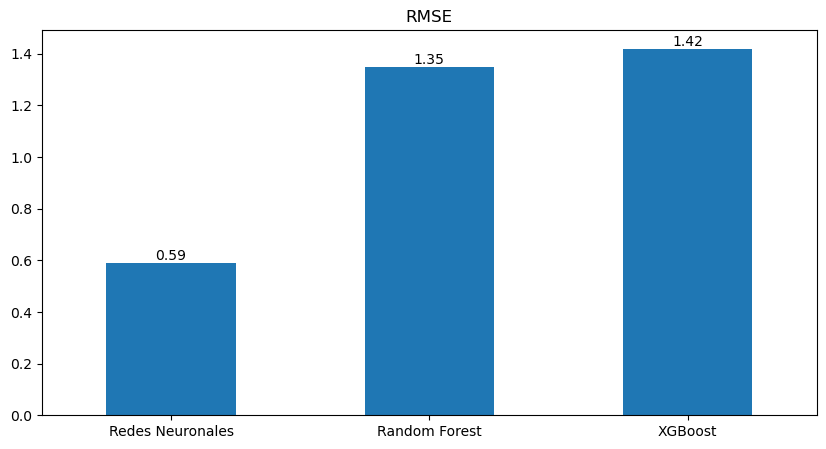

In [76]:
df_RMSE = pd.DataFrame(pd.DataFrame({'Modelo': ['Redes Neuronales', 'Random Forest', 'XGBoost'], 'RMSE': lista_RMSE_reactive}))

ax_RMSE = df_RMSE.plot.bar(x = 'Modelo', y = 'RMSE', rot = 0, figsize = (10, 5), legend = False, xlabel = '', title = 'RMSE')
for container in ax_RMSE.containers:
    ax_RMSE.bar_label(container)